In [1]:
import zipfile, os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

# Extraer los datos
zip_path = "Data.zip"
data_dir = Path("data")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

# Verificar contenido
for root, dirs, files in os.walk(data_dir):
    print(root, len(files), "files")

data 0 files
data/__MACOSX 0 files
data/__MACOSX/Data 2 files
data/Data 3 files


In [2]:
import os
print("Directorio actual:", os.getcwd())


Directorio actual: /content


In [3]:
import zipfile
from pathlib import Path
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Ruta correcta al ZIP (relativa al working directory actual)
base_dir = Path("/content")
data_dir = base_dir / "data" / "Data"
zip_path = data_dir / "airplanes.zip"
extract_dir = data_dir / "images"

print("Ruta absoluta del ZIP:", zip_path)

# Extraer solo si aún no se ha hecho
if not extract_dir.exists():
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Dataset extraído en: {extract_dir}")
else:
    print(f"Dataset ya existe en: {extract_dir}")


csv_path = data_dir / "Airplanes.csv"
df = pd.read_csv(csv_path)
print("Primeras filas del dataset:")
print(df.head())

Ruta absoluta del ZIP: /content/data/Data/airplanes.zip
Dataset extraído en: /content/data/Data/images
Primeras filas del dataset:
   Unnamed: 0           Image  y_top  y_bottom  x_top  x_bottom      label
0           0  image_0001.jpg     30       137     49       349  Airplanes
1           0  image_0002.jpg     35       153     59       342  Airplanes
2           0  image_0003.jpg     36       135     47       331  Airplanes
3           0  image_0004.jpg     24       141     47       342  Airplanes
4           0  image_0005.jpg     18       146     48       339  Airplanes


In [4]:
def corners_to_coco(x_top, y_top, x_bottom, y_bottom):
    """
    Convierte coordenadas de esquina (x_top, y_top, x_bottom, y_bottom)
    al formato COCO: [x_min, y_min, width, height]
    """
    x = x_top
    y = y_top
    width = x_bottom - x_top
    height = y_bottom - y_top
    return [x, y, width, height]

In [5]:
# Aplicar conversión
df[['x', 'y', 'width', 'height']] = df.apply(
    lambda row: pd.Series(corners_to_coco(row.x_top, row.y_top, row.x_bottom, row.y_bottom)),
    axis=1
)

print("\nEjemplo de coordenadas convertidas a COCO:")
print(df[['Image', 'x', 'y', 'width', 'height']].head())


Ejemplo de coordenadas convertidas a COCO:
            Image   x   y  width  height
0  image_0001.jpg  49  30    300     107
1  image_0002.jpg  59  35    283     118
2  image_0003.jpg  47  36    284      99
3  image_0004.jpg  47  24    295     117
4  image_0005.jpg  48  18    291     128


In [6]:
images_dir = data_dir / "images" / "airplanes"

In [7]:
def show_image_with_bbox(row, img_dir):
    """
    Visualiza la imagen con su bounding box en formato COCO.
    """
    img_path = img_dir / row["Image"]
    if not img_path.exists():
        print(f"Imagen no encontrada: {img_path}")
        return

    img = cv2.imread(str(img_path))
    if img is None:
        print(f"No se pudo leer: {img_path}")
        return

    x, y, w, h = int(row.x), int(row.y), int(row.width), int(row.height)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{row['Image']} — Bounding Box")
    plt.axis('off')
    plt.show()

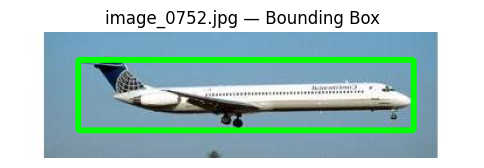

In [9]:
sample_row = df.sample(1).iloc[0]
show_image_with_bbox(sample_row, images_dir)

Modelo listo en: cuda

========== Entrenando solo la cabeza ==========
Epoch 1 — Loss: 0.0388
Epoch 2 — Loss: 0.0165
Epoch 3 — Loss: 0.0159

========== Fine-tuning completo ==========
Epoch 1 — Loss: 0.0158 — IoU: 0.5349
Epoch 2 — Loss: 0.0156 — IoU: 0.5419
Epoch 3 — Loss: 0.0154 — IoU: 0.5486
Epoch 4 — Loss: 0.0153 — IoU: 0.5499
Epoch 5 — Loss: 0.0151 — IoU: 0.5551
Epoch 6 — Loss: 0.0150 — IoU: 0.5575
Epoch 7 — Loss: 0.0148 — IoU: 0.5659
✅ Entrenamiento completado.


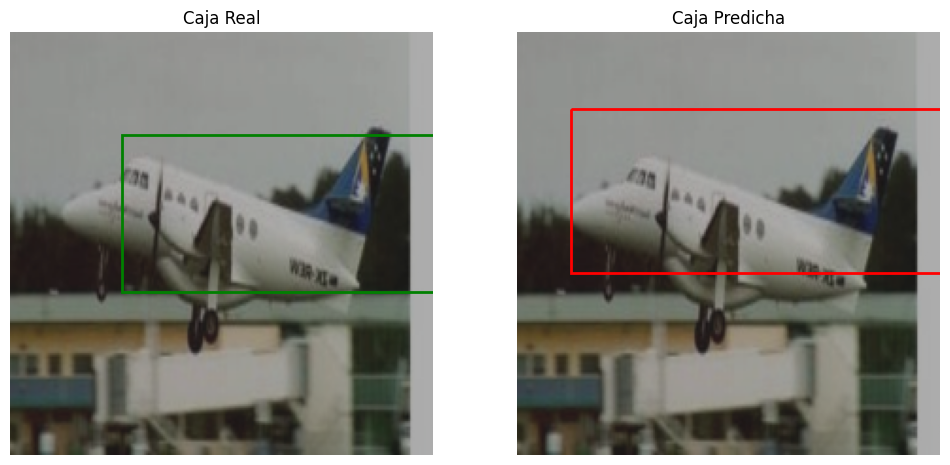

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1. Funciones para normalizar y desnormalizar bounding boxes
# ============================================================

def normalize_box(x, y, w, h, W=224, H=224):
    return [x/W, y/H, w/W, h/H]

def denormalize_box(x, y, w, h, W=224, H=224):
    return [x*W, y*H, w*W, h*H]

# ============================================================
# 2. Dataset con normalización incluida
# ============================================================

class AirplaneBboxDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.img_dir / row["Image"]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)  # tensor [3,224,224]

        # Normalizamos bbox a [0,1]
        target = torch.tensor(
            normalize_box(row.x, row.y, row.width, row.height),
            dtype=torch.float32
        )
        return img, target

# ============================================================
# 3. Transformaciones + DataLoader
# ============================================================

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomCrop((224,224)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

dataset = AirplaneBboxDataset(df, images_dir, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# ============================================================
# 4. Modelo
# ============================================================

class BoundingBoxRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(weights="IMAGENET1K_V1")
        base.fc = nn.Identity()
        self.backbone = base
        self.reg_head = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 4),
            nn.Sigmoid()    # Predicciones en rango [0,1]
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.reg_head(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BoundingBoxRegressor().to(device)
print("Modelo listo en:", device)

# ============================================================
# 5. Métricas: SmoothL1Loss + IoU
# ============================================================

criterion = nn.SmoothL1Loss(beta=1.0)

def iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    xa1, ya1 = x1, y1
    xa2, ya2 = x1 + w1, h1 + y1
    xb1, yb1 = x2, y2
    xb2, yb2 = x2 + w2, h2 + y2

    inter_w = max(0, min(xa2, xb2) - max(xa1, xb1))
    inter_h = max(0, min(ya2, yb2) - max(ya1, yb1))
    inter = inter_w * inter_h
    union = w1*h1 + w2*h2 - inter + 1e-9
    return inter / union

# ============================================================
# 6. Entrenamiento en dos fases
# ============================================================

# Fase 1: Congelar backbone y entrenar solo la cabeza
for p in model.backbone.parameters():
    p.requires_grad = False

optimizer = torch.optim.Adam(model.reg_head.parameters(), lr=1e-4)

print("\n========== Entrenando solo la cabeza ==========")
for epoch in range(3):
    model.train()
    total_loss = 0
    for imgs, targets in dataloader:
        imgs, targets = imgs.to(device), targets.to(device)

        preds = model(imgs)
        loss = criterion(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} — Loss: {total_loss / len(dataloader):.4f}")

# Fase 2: Descongelar todo y fine-tune completo
for p in model.backbone.parameters():
    p.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

print("\n========== Fine-tuning completo ==========")
for epoch in range(7):
    model.train()
    total_loss = 0
    total_iou = 0

    for imgs, targets in dataloader:
        imgs, targets = imgs.to(device), targets.to(device)
        preds = model(imgs)

        loss = criterion(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        with torch.no_grad():
            total_iou += np.mean([iou(p.detach().cpu().numpy(), t.detach().cpu().numpy())
                                  for p, t in zip(preds.clamp(0,1), targets)])


    print(f"Epoch {epoch+1} — Loss: {total_loss/len(dataloader):.4f} — IoU: {total_iou/len(dataloader):.4f}")

print("✅ Entrenamiento completado.")

# ============================================================
# 7. Visualización de predicción final
# ============================================================

i = 15
img, target = dataset[i]
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device)).cpu().numpy()[0]

img_np = img.permute(1,2,0).numpy()

# Desnormalizar ambas
tx, ty, tw, th = denormalize_box(*target.numpy())
px, py, pw, ph = denormalize_box(*pred)

fig, axs = plt.subplots(1, 2, figsize=(12,6))

# Real
axs[0].imshow(img_np)
axs[0].add_patch(plt.Rectangle((tx,ty), tw,th, fill=False, color='green', linewidth=2))
axs[0].set_title("Caja Real")
axs[0].axis('off')

# Predicha
axs[1].imshow(img_np)
axs[1].add_patch(plt.Rectangle((px,py), pw,ph, fill=False, color='red', linewidth=2))
axs[1].set_title("Caja Predicha")
axs[1].axis('off')

plt.show()



In [27]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def draw_bbox_with_coords(
    img,
    x_top, y_top, x_bottom, y_bottom,
    *,
    normalized=False,         # True si las coords que pasas están en [0,1]
    show_values="px",         # "px" | "norm" | "both"
    lw=3
):
    """
    Dibuja bbox a partir de 2 puntos y muestra las coordenadas numéricas en los 'chips'.
    - show_values:
        "px"   -> muestra valores en píxeles
        "norm" -> muestra valores normalizados [0..1] con 3 decimales
        "both" -> muestra px y normalizado
    """
    # a np array
    img_np = np.asarray(img) if not isinstance(img, np.ndarray) else img
    H, W = img_np.shape[:2]

    # leer puntos crudos
    if normalized:
        # vienen en [0,1] -> escalar a px
        xt_raw = float(x_top)    * W
        yt_raw = float(y_top)    * H
        xb_raw = float(x_bottom) * W
        yb_raw = float(y_bottom) * H
        xt_norm, yt_norm = float(x_top), float(y_top)
        xb_norm, yb_norm = float(x_bottom), float(y_bottom)
    else:
        # vienen en píxeles
        xt_raw = float(x_top); yt_raw = float(y_top)
        xb_raw = float(x_bottom); yb_raw = float(y_bottom)
        # normalizados para mostrar si se pide "both" o "norm"
        xt_norm, yt_norm = xt_raw / W, yt_raw / H
        xb_norm, yb_norm = xb_raw / W, yb_raw / H

    # clamp a límites de imagen
    def clamp(v, lo, hi): return max(lo, min(hi, v))
    xt = clamp(xt_raw, 0, W-1); yt = clamp(yt_raw, 0, H-1)
    xb = clamp(xb_raw, 0, W-1); yb = clamp(yb_raw, 0, H-1)

    # bbox
    x1, x2 = sorted([xt, xb]); y1, y2 = sorted([yt, yb])
    w, h = x2 - x1, y2 - y1

    # texto a mostrar
    def fmt_chip(px, py, nx, ny):
        if show_values == "px":
            return f"({int(round(px))}, {int(round(py))})"
        elif show_values == "norm":
            return f"({nx:.3f}, {ny:.3f})"
        else:  # both
            return f"({int(round(px))}, {int(round(py))})  [{nx:.3f}, {ny:.3f}]"

    txt_top    = fmt_chip(xt, yt, xt_norm, yt_norm)
    txt_bottom = fmt_chip(xb, yb, xb_norm, yb_norm)

    # plot
    fig, ax = plt.subplots(figsize=(7,4))
    ax.imshow(img_np)

    # marco
    ax.add_patch(plt.Rectangle((x1, y1), w, h, fill=False, edgecolor="red", linewidth=lw))

    # chips con texto
    ax.text(
        xt, yt-8, txt_top, color="white", fontsize=10, weight="bold",
        va="bottom", ha="left",
        bbox=dict(boxstyle="round,pad=0.25", facecolor="red", edgecolor="red")
    )
    ax.text(
        xb, yb+8, txt_bottom, color="white", fontsize=10, weight="bold",
        va="top", ha="right",
        bbox=dict(boxstyle="round,pad=0.25", facecolor="red", edgecolor="red")
    )

    ax.axis("off")
    plt.tight_layout()
    plt.show()




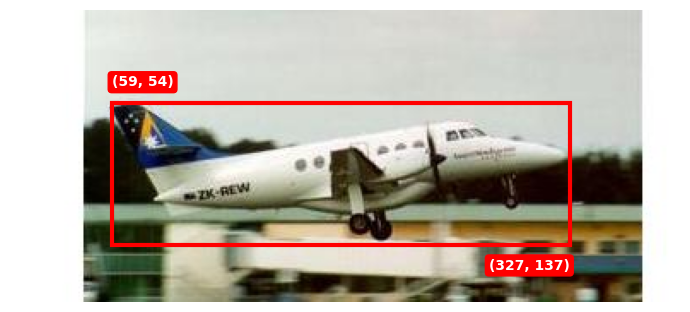

In [29]:
row = df.iloc[15]
img = Image.open(images_dir / row["Image"]).convert("RGB")

draw_bbox_with_coords(img, row.x_top, row.y_top, row.x_bottom, row.y_bottom,
                      normalized=False, show_values="px")



